# Starters

## Imports

In [2]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import skimage.measure
from PIL import Image
import re
import time
from skimage.io import imsave, imread
# from skimage.util import img_as_ubyte
from scipy import ndimage
import deepcell
import deepcell.applications.cell_tracking
from deepcell.applications import Mesmer
from skimage import (
    color, data, color, io, filters, measure, morphology, segmentation
)
import cv2
from skimage import measure
# import torch
import glob
import seaborn as sns
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import feature
import math
import copy
import glob
import colorcet as cc
from collections import Counter
import ipynb
# import plotly.io
# import plotly.express as px

2022-06-19 09:35:00.389455: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Define Functions

In [3]:
# For sorting lists
def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    l.sort(key=alphanum_key)

# Function for showing tifs quickly
def showtif(file, zstack=0, channel=0, verbose=True):
    if os.path.isfile(file):
        skimg = io.imread(file, plugin='tifffile')
    else:
        skimg = file
    if len(skimg.shape) == 2:
        img = skimg
    if len(skimg.shape) == 3:
        img = skimg[zstack]
    if len(skimg.shape) == 4:
        img = skimg[zstack, channel]
    if verbose == True:
        if len(skimg.shape) == 2:
            print(skimg.shape, "\n", "Single layer of size {} x {}".format(skimg.shape[0], skimg.shape[1]))
        else:
            print(skimg.shape, "\n", "Showing Z-stack {} of {}".format(zstack, skimg.shape[0]-1))
    plt.axis('off')
    a = plt.imshow(img, cmap='gray')
    return a

# Function for returning values from dictionary keys
def get_key(dict, val):
    if type(val) == float:
        for key, value in dict.items():
            if val == value:
                return key
        return "key doesn't exist"
    if type(val) == list:
        outkeys = []
        for i in val:
            for key, value in dict.items():
                if i == value:
                    outkeys.append(key)
        return outkeys

## Set Directories

In [4]:
SCRIPTDIR = os.path.realpath('./')
SCRIPTDIR = '/scratch/ns4964/lionnet/scripts/'

os.chdir(SCRIPTDIR)
os.chdir('../inputs/train3D/')
DATADIR = os.getcwd()

os.chdir(SCRIPTDIR)
os.chdir('../output/Mesmer/train3d/')
OUTDIR = os.getcwd()

os.chdir(SCRIPTDIR)
os.chdir('../output/Interpolated/')
INTERPDIR = os.getcwd()

os.chdir(SCRIPTDIR)

## Bring in Data

In [5]:
# Only pull folders from the data directory
os.chdir(DATADIR)
imgfolders = []
for file in os.listdir():
    if os.path.isdir(file):
        imgfolders.append(file)

sort_nicely(imgfolders)

# Create reference df for all images
imgdf = pd.DataFrame(imgfolders, columns=['imgfolder'])
imgdf['gappath'] = ''
imgdf['imagepath'] = ''
imgdf['labelpath'] = ''
imgdf['zlayers'] = ''
imgdf['x'] = ''
imgdf['y'] = ''

for index, row in imgdf.iterrows():
    indir = os.path.join(DATADIR, imgdf.iloc[index]['imgfolder'])
    imgdf.at[index, 'gappath'] = os.path.join(indir, 'gap.tif')
    imgdf.at[index, 'imagepath'] = os.path.join(indir, 'image.tif')
    imgdf.at[index, 'labelpath'] = os.path.join(indir, 'label.tif')
    im = imgdf['imagepath'][0]
    skimg = io.imread(im, plugin='tifffile')
    imgdf.at[index, 'zlayers'] = skimg.shape[0]
    imgdf.at[index, 'x'] = skimg.shape[1]
    imgdf.at[index, 'y'] = skimg.shape[2]
imgdf

,imgfolder,gappath,imagepath,labelpath,zlayers,x,y
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
1,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
2,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
3,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
4,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
5,C1-FB323A_CSC_Rd1_6,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
6,C1-FB323A_CSC_Rd1_7,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
7,C1-FB323A_CSC_Rd1_8,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
8,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
9,C1-FB323A_CSC_Rd1_10,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024


In [137]:
# Small DF to test loops
testdf = imgdf.loc[0:2].copy()
testdf = testdf.reset_index(drop=True)
testdf

,imgfolder,gappath,imagepath,labelpath,zlayers,x,y
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
1,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
2,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024


In [ ]:
# Single image df
singledf = imgdf.loc[[2]].copy()
singledf = singledf.reset_index(drop=True)
# singledf.loc[0]['imgfolder']
singledf

## Large Comparison DF

In [9]:
compdf = imgdf.copy()
#For Labels
# compdf = compdf.drop(['imagepath','gappath','zlayers','x','y'],axis=1)
# For Images
compdf = compdf.drop(['gappath','zlayers','x','y'],axis=1)

compdf.columns = ['imgname','imgpath','maskpath']

compdf.insert(3,'0',"")
compdf.insert(4,'1',"")
compdf.insert(5,'2',"")
compdf.insert(6,'3',"")

compdf = pd.melt(compdf,id_vars=['imgname','imgpath','maskpath'])
compdf = compdf.drop(['value'], axis = 1)

compdf.columns = ['imgname','imgfile','labelpath', 'added']
compdf = compdf.sort_values(by=['imgname','added'])
compdf = compdf.reset_index(drop=True)

compdf[0:6]

,imgname,imgfile,labelpath,added
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,1
2,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,2
3,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3
4,C1-FB323A_CSC_Rd1_10,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0
5,C1-FB323A_CSC_Rd1_10,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,1


In [10]:
os.chdir(INTERPDIR)
imname = compdf.loc[0]['imgname']
added = compdf.loc[1]['added']
print(imname,added)
glob.glob(imname+"-image*-"+added+"*")
os.path.join(INTERPDIR, glob.glob(imname+"-*image*-"+added+"*")[0])

C1-FB323A_CSC_Rd1_1 1


'/scratch/ns4964/lionnet/output/Interpolated/C1-FB323A_CSC_Rd1_1-image-addedinterplayers-1.tiff'

In [11]:
os.chdir(INTERPDIR)
for i in compdf.index:
    imname = compdf.imgname.iloc[i]
    added = compdf.added.iloc[i]
    if added == '0':
        continue
    compdf.at[i,'imgfile'] = os.path.join(INTERPDIR, glob.glob(imname+"-*image*-"+added+"*")[0])
    compdf.at[i,'labelpath'] = os.path.join(INTERPDIR, glob.glob(imname+"-*mask*-"+added+"*")[0])
compdf

,imgname,imgfile,labelpath,added
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/output/Interpolated/C1...,/scratch/ns4964/lionnet/output/Interpolated/C1...,1
2,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/output/Interpolated/C1...,/scratch/ns4964/lionnet/output/Interpolated/C1...,2
3,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/output/Interpolated/C1...,/scratch/ns4964/lionnet/output/Interpolated/C1...,3
4,C1-FB323A_CSC_Rd1_10,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0
...,...,...,...,...
87,C1-FB323A_CSC_Rd1_8,/scratch/ns4964/lionnet/output/Interpolated/C1...,/scratch/ns4964/lionnet/output/Interpolated/C1...,3
88,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0
89,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/output/Interpolated/C1...,/scratch/ns4964/lionnet/output/Interpolated/C1...,1
90,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/output/Interpolated/C1...,/scratch/ns4964/lionnet/output/Interpolated/C1...,2


In [142]:
# Single image df
singledf = compdf.loc[0:3].copy()
singledf = singledf.reset_index(drop=True)
# singledf.loc[0]['imgfolder']
singledf

,imgname,imgfile,labelpath,added
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/output/Interpolated/C1...,/scratch/ns4964/lionnet/output/Interpolated/C1...,1
2,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/output/Interpolated/C1...,/scratch/ns4964/lionnet/output/Interpolated/C1...,2
3,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/output/Interpolated/C1...,/scratch/ns4964/lionnet/output/Interpolated/C1...,3


# Apply Mesmer

In [ ]:
run = True # 1hr for all images
run = False

saveims = True
saveims = False

df = singledf
# df=testdf
# df=imgdf
df = compdf


if run:
    start_time = time.time()
    for i in df.index:
        imgname = df.iloc[i]['imgname']
        imgfile = df.iloc[i]['imgfile']
        fakemem = df.iloc[i]['labelpath']
        addedlayers = df.iloc[i]['added']

        # for running Mesmer
        nuc_channel = imread(imgfile, plugin='tifffile')
        mem_channel = imread(fakemem, plugin='tifffile')
        if len(nuc_channel.shape) == 4:
            nuc_channel = color.rgb2gray(nuc_channel)
        # Required to have 4 dimensions: [batch, x, y, channel], with nuclear channel first and cytoplasmic channel second."
        im = np.stack((nuc_channel, mem_channel), axis=-1)
        app = Mesmer()
        meslabel = app.predict(im,image_mpp = 0.175,compartment='nuclear')
        meslabel = meslabel[...,0]
        meslabel = (meslabel>0)

        if saveims:
            os.chdir(OUTDIR)
            mesoutname = imgname+"-"+"mesmask-"+"interpzs-"+str(addedlayers)+'.tiff'

            pilimages = []
            for j in range(meslabel.shape[0]):
                new = Image.fromarray(meslabel[j])
                pilimages.append(new)
            pilimages[0].save(mesoutname,format='TIFF',save_all=True,append_images=pilimages[1:])


In [150]:
print("--- %s seconds for %s file(s) ---" % (round((time.time() - start_time),0),len(df)))

--- 3475.0 seconds for 92 file(s) ---


In [147]:
for i in df.index:
    imgname = df.iloc[i]['imgname']
    imgfile = df.iloc[i]['imgfile']
    fakemem = df.iloc[i]['labelpath']
    addedlayers = df.iloc[i]['added']
    print(i, imgname, addedlayers)

0 C1-FB323A_CSC_Rd1_1 0
1 C1-FB323A_CSC_Rd1_1 1
2 C1-FB323A_CSC_Rd1_1 2
3 C1-FB323A_CSC_Rd1_1 3


In [151]:
# len(nuc_channel.shape)
# mem_channel.shape

In [ ]:
# a = color.rgb2gray(nuc_channel)
# a.shape
# showtif(a)

# Comparisons

## Make df for comapring all images

In [152]:
os.chdir(OUTDIR)
interptiffs = []
for file in os.listdir():
    if os.path.isdir(file):
        continue
    interptiffs.append(file)
# interptiffs = sort_nicely(interptiffs)
len(interptiffs)

92

In [153]:
fulltiffs = []
for file in interptiffs:
    fulltiffs.append(os.path.join(OUTDIR,file))
interptiffs = fulltiffs

In [154]:
mesdf = pd.DataFrame(interptiffs, columns=['maskfile'])
mesdf.insert(0,'imgname','')
mesdf.insert(len(mesdf.columns),'added','')
mesdf.insert(len(mesdf.columns),'method','mesmer')
mesdf

,imgname,maskfile,added,method
0,,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,,mesmer
1,,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,,mesmer
2,,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,,mesmer
3,,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,,mesmer
4,,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,,mesmer
...,...,...,...,...
87,,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,,mesmer
88,,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,,mesmer
89,,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,,mesmer
90,,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,,mesmer


In [155]:
testfile = interptiffs[0]
testfile

'/scratch/ns4964/lionnet/output/Mesmer/train3d/C1-FB323A_CSC_Rd1_4-mesmask-interpzs-1.tiff'

In [156]:
testfile.split("-")[-1].split(".")[0]
testfile.split("/")[-1]

'C1-FB323A_CSC_Rd1_4-mesmask-interpzs-1.tiff'

In [157]:
imgnames = []
for file in interptiffs:
    local = file.split("/")[-1]
    imgname = local.split("-")[0]+"-"+local.split("-")[1]
    imgnames.append(local.split("-")[0]+"-"+local.split("-")[1])

In [158]:
for i in mesdf.index:
    imgname = mesdf.loc[i]['maskfile'].split("/")[-1].split("-")[0]+"-"+mesdf.loc[i]['maskfile'].split("/")[-1].split("-")[1]
    added = mesdf.loc[i]['maskfile'].split("-")[-1].split(".")[0]
    mesdf.at[i,'imgname'] = imgname
    mesdf.at[i,'added'] = added
mesdf

,imgname,maskfile,added,method
0,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,1,mesmer
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,2,mesmer
2,C1-FB323A_CSC_Rd1_19,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,2,mesmer
3,C1-FB323A_CSC_Rd1_14,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,0,mesmer
4,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,1,mesmer
...,...,...,...,...
87,C1-FB323A_CSC_Rd1_8,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,1,mesmer
88,C1-FB323A_CSC_Rd1_21,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,0,mesmer
89,C1-FB323A_CSC_Rd1_16,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,3,mesmer
90,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,2,mesmer


In [159]:
# Pull the paths to the GT Masks for comparison.
pathstoadd = pd.DataFrame(mesdf.imgname, columns=mesdf.columns)
pathstoadd = pathstoadd.drop_duplicates()
pathstoadd = pathstoadd.reset_index(drop=True)
pathstoadd.added = 0
pathstoadd.method = 'manual'
pathstoadd

,imgname,maskfile,added,method
0,C1-FB323A_CSC_Rd1_4,NaN,0,manual
1,C1-FB323A_CSC_Rd1_1,NaN,0,manual
2,C1-FB323A_CSC_Rd1_19,NaN,0,manual
3,C1-FB323A_CSC_Rd1_14,NaN,0,manual
4,C1-FB323A_CSC_Rd1_5,NaN,0,manual
5,C1-FB323A_CSC_Rd1_15,NaN,0,manual
6,C1-FB323A_CSC_Rd1_18,NaN,0,manual
7,C1-FB323A_CSC_Rd1_10,NaN,0,manual
8,C1-FB323A_CSC_Rd1_16,NaN,0,manual
9,C1-FB323A_CSC_Rd1_21,NaN,0,manual


In [160]:
test = pathstoadd.iloc[0].imgname
imgdf[imgdf.imgfolder==test].labelpath.to_list()[0]

'/scratch/ns4964/lionnet/inputs/train3D/C1-FB323A_CSC_Rd1_4/label.tif'

In [161]:
for i in pathstoadd.index:
    imgname = pathstoadd.iloc[i].imgname
    maskpath = imgdf[imgdf.imgfolder == imgname].labelpath.to_list()[0]
    pathstoadd.at[i, 'maskfile'] = maskpath
pathstoadd

,imgname,maskfile,added,method
0,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,manual
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,manual
2,C1-FB323A_CSC_Rd1_19,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,manual
3,C1-FB323A_CSC_Rd1_14,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,manual
4,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,manual
5,C1-FB323A_CSC_Rd1_15,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,manual
6,C1-FB323A_CSC_Rd1_18,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,manual
7,C1-FB323A_CSC_Rd1_10,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,manual
8,C1-FB323A_CSC_Rd1_16,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,manual
9,C1-FB323A_CSC_Rd1_21,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,manual


In [162]:
fulldf = pd.concat([mesdf,pathstoadd])
fulldf = fulldf.sort_values(by = ['imgname', 'added'])
fulldf = fulldf.reset_index(drop = True)
fulldf.insert(len(fulldf.columns),"MSE",0)
fulldf.insert(len(fulldf.columns),"SSIM",0)
fulldf

,imgname,maskfile,added,method,MSE,SSIM
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,manual,0,0
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,0,mesmer,0,0
2,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,1,mesmer,0,0
3,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,2,mesmer,0,0
4,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,3,mesmer,0,0
...,...,...,...,...,...,...
110,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,manual,0,0
111,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,0,mesmer,0,0
112,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,1,mesmer,0,0
113,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,2,mesmer,0,0


## Run Comparison

In [163]:
minidf = fulldf[fulldf.imgname=='C1-FB323A_CSC_Rd1_11'].copy()
minidf=minidf.reset_index(drop=True)
minidf

,imgname,maskfile,added,method,MSE,SSIM
0,C1-FB323A_CSC_Rd1_11,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,manual,0,0
1,C1-FB323A_CSC_Rd1_11,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,0,mesmer,0,0
2,C1-FB323A_CSC_Rd1_11,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,1,mesmer,0,0
3,C1-FB323A_CSC_Rd1_11,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,2,mesmer,0,0
4,C1-FB323A_CSC_Rd1_11,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,3,mesmer,0,0


In [188]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

df = fulldf

for i in df.index:
    # Bring in the mask of focus and the reference mask
    imname = df.imgname.iloc[i]
    added = int(df.added.iloc[i])
    origind = df.index[(df['method'] == 'manual')&(df['imgname']==imname)].tolist()[0]
    orig = io.imread(df.maskfile.iloc[origind],plugin='tifffile')
    new = io.imread(df.maskfile.iloc[i],plugin='tifffile')
    # pull out only the layers from the GT mask.
    origpositions = []
    for j in range(0, np.max(new.shape[0]), added+1):
        origpositions.append(j)

    newstack = np.empty((orig.shape))
    newtifcounter = 0
    for j in origpositions:
        newstack[newtifcounter] = new[j]
        newtifcounter+=1
    mse = []
    strucsim = []
    for j in range(orig.shape[0]):
        mse.append(mean_squared_error(newstack[j],orig[j]))
        ssim = strucsim.append(skimage.metrics.structural_similarity(newstack[j],orig[j]))
    df.at[i,'MSE'] = np.mean(mse)
    df.at[i, 'SSIM'] = np.mean(strucsim)
    # print(i, imname, origind, added, new.shape)
    # print(origpositions)
df

/state/partition1/job-21186823/ipykernel_3769037/3006014876.py:27: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim = strucsim.append(skimage.metrics.structural_similarity(newstack[j],orig[j]))


,imgname,maskfile,added,method,MSE,SSIM
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,manual,0.000000,1.000000
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,0,mesmer,18761.649611,0.605784
2,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,1,mesmer,18755.115802,0.595744
3,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,2,mesmer,18755.115802,0.595744
4,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,3,mesmer,18755.115802,0.595744
...,...,...,...,...,...,...
110,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,manual,0.000000,1.000000
111,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,0,mesmer,16044.606443,0.605096
112,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,1,mesmer,16042.327565,0.586358
113,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,2,mesmer,16042.327565,0.586358


In [189]:
fulldf

,imgname,maskfile,added,method,MSE,SSIM
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,manual,0.000000,1.000000
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,0,mesmer,18761.649611,0.605784
2,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,1,mesmer,18755.115802,0.595744
3,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,2,mesmer,18755.115802,0.595744
4,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,3,mesmer,18755.115802,0.595744
...,...,...,...,...,...,...
110,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,0,manual,0.000000,1.000000
111,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,0,mesmer,16044.606443,0.605096
112,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,1,mesmer,16042.327565,0.586358
113,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/output/Mesmer/train3d/...,2,mesmer,16042.327565,0.586358


0
(7, 1024, 1024) 
 Showing Z-stack 0 of 6
(7, 1024, 1024) 
 Showing Z-stack 0 of 6


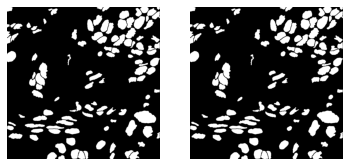

In [178]:
print(added)
plt.subplot(1,2,1)
showtif(newstack)
plt.subplot(1,2,2)
showtif(orig)